In [1]:
#using Pkg; Pkg.update()
using Pkg; Pkg.resolve()
using SplitApplyCombine
using ParallelTemperingMonteCarlo
using DelimitedFiles
using StaticArrays
using Random, Plots

using BenchmarkTools

  No Changes to `~/Documents/ParallelTemperingMonteCarlo.jl/Project.toml`
  No Changes to `~/Documents/ParallelTemperingMonteCarlo.jl/Manifest.toml`


Below was used to benchmark generating vectors

In [2]:
# genvector1(max_displacement) = max_displacement * (rand(-0.5:0.001:0.5,3))

# genvector2(max_displacement) = SVector((rand()-0.5)*max_displacement,(rand()-0.5)*max_displacement,(rand()-0.5)*max_displacement)
# @benchmark genvector1(rand())
# @benchmark genvector2(rand())

Below is the main code to load 13 atom neon ELJ

In [2]:
n_atoms = 13

# temperature grid
ti = 5.
tf = 16.
n_traj = 32

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details

mc_cycles = 400000 #default 20% equilibration cycles on top

mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
pos_ne13 = [[2.825384495892464, 0.928562467914040, 0.505520149314310],
[2.023342172678102,	-2.136126268595355, 0.666071287554958],
[2.033761811732818,	-0.643989413759464, -2.133000349161121],
[0.979777205108572,	2.312002562803556, -1.671909307631893],
[0.962914279874254,	-0.102326586625353, 2.857083360096907],
[0.317957619634043,	2.646768968413408, 1.412132053672896],
[-2.825388342924982, -0.928563755928189, -0.505520471387560],
[-0.317955944853142, -2.646769840660271, -1.412131825293682],
[-0.979776174195320, -2.312003751825495, 1.671909138648006],
[-0.962916072888105, 0.102326392265998,	-2.857083272537599],
[-2.023340541398004, 2.136128558801072,	-0.666071089291685],
[-2.033762834001679, 0.643989905095452, 2.132999911364582],
[0.000002325340981,	0.000000762100600, 0.000000414930733]]

#convert to Bohr
AtoBohr = 1.8897259886
pos_ne13 = pos_ne13 * AtoBohr

length(pos_ne13) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne13 = SphericalBC(radius=5.32*AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne13, bc_ne13)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[])

Below is the comprehensive testing performed on making a vectorised displacement function

In [4]:
# function testtime(mc_states)
#     for state in mc_states
#         ran = rand(1:length(state.config.pos))
#         trial_pos =atom_displacement(state.config.pos[ran],state.max_displ[1],state.config.bc)
#     end
# end
# @benchmark testtime(mc_states)
# # rand(1:n_atoms,n_traj)
# # V = [1 2 3; 4 5 6; 7 8 9]
# # V[:,1]
# function atom_disp(mc_state,index)
#     trial_pos = atom_displacement(mc_state.config.pos[index],mc_state.max_displ[1],mc_state.config.bc)
#     return trial_pos
# end
# function atom_disp!(mc_state,index,trial_pos::SVector)
#     trial_pos = atom_displacement(mc_state.config.pos[index],mc_state.max_displ[1],mc_state.config.bc)
#     return trial_pos
# end

# indices = rand(1:n_atoms,n_traj)

# # trial_pos = atom_disp.(mc_states,indices)

# @benchmark begin   
#     indices = rand(1:n_atoms,n_traj)
#     trial_positions = atom_disp.($mc_states,indices)
# end

# @benchmark begin 
#     indices = rand(1:n_atoms,n_traj)
#     trial_positions =  [@SVector zeros(3) for i in 1:n_traj]
#     atom_disp!.($mc_states,indices,trial_positions)
# end
# function generate_displacements(mc_states,mc_params)
#     indices=rand(1:mc_params.n_atoms,mc_params.n_traj)
#     trial_positions = atom_disp.(mc_states,indices)
#     return indices,trial_positions
# end
# @benchmark generate_displacements(mc_states,mc_params)
# @benchmark dimer_energy_atom(1, mc_states[1].dist2_mat[1,:], pot)
# @benchmark dimer_energy_atom(1, mc_states[1].dist2_mat[:,1], pot)

In [3]:
ptmc_run!(mc_states, move_strat, mc_params, pot, ensemble, results; save_ham = false)

Total number of moves per MC cycle: 13



equilibration done


MC loop done.


[0.00032551790401069426, 0.00034083503997973594, 0.00036061526512608835, 0.000376431381132827, 0.00039286566976014914, 0.00041860534310469186, 0.0004416399569559045, 0.0004609085345316111, 0.00048825688204616257, 0.0005166226657859648, 0.0005444143117827024, 0.000565236008198619, 0.0006072778047699107, 0.000651301110688972, 0.000704889706236099, 0.0007751519426040778, 0.0008088658970509516, 0.0009326333647743557, 0.0010851914270104779, 0.0013305404241049708, 0.0016124425990313698, 0.0019392912132778653, 0.002438157675227783, 0.0029699134478113885, 0.0033115470663294317, 0.0033341813556495552, 0.0030903162202667476, 0.0028786957025777734, 0.002632680192421927, 0.0023825071050105552, 0.002133352973907671, 0.002015313495866899]
done


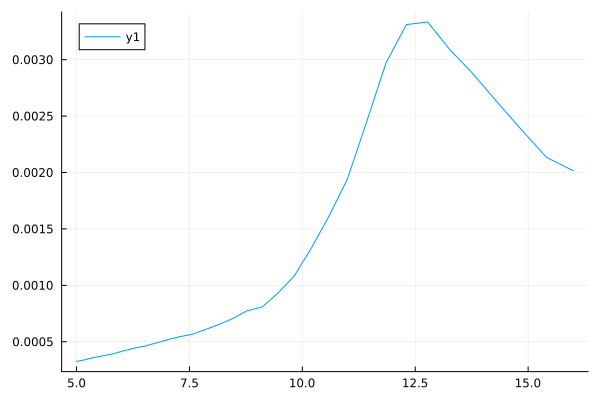

In [4]:
plot(temp.t_grid,results.heat_cap)


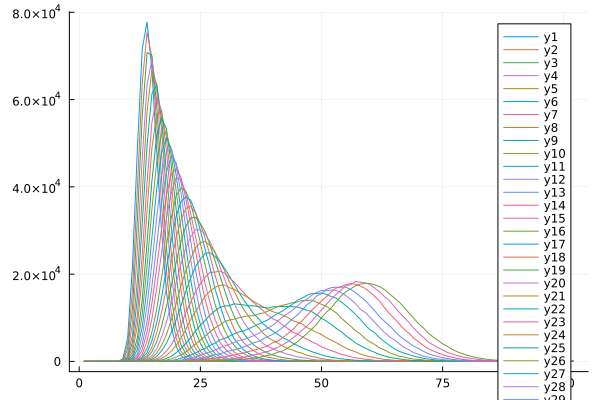

In [5]:
data = [results.en_histogram[i] for i in 1:n_traj]
plot(data)

B Vector Calculated
A Matrix Calculated
system solved!
Entropy Found
Quantities found
analysis complete


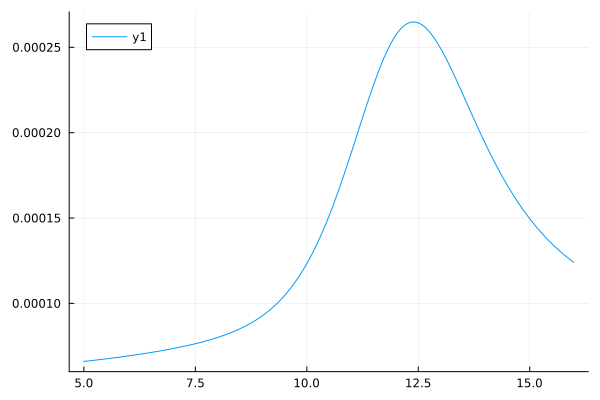

In [6]:
multihistogram(results,temp)
file = open("analysis.NVT","r+")
analysis = readdlm(file)
plot(analysis[2:end,1],analysis[2:end,3])

Below is the test for generating energy after displacement

In [6]:
# function get_energy_dimer(pos,i_atom,mc_state,pot)
#     dist2_new = [distance2(pos,b) for b in mc_state.config.pos]
#     dist2_new[i_atom] = 0.

#     energy = dimer_energy_atom(i_atom,dist2_new,pot)

#     return energy, dist2_new
# end

# function generate_energies(mc_states,trial_positions,indices,pot)
#     output = get_energy_dimer.(trial_positions,indices,mc_states,Ref(pot))
#     return output
# end
# # indices,trial_positions = generate_displacements(mc_states,mc_params)

# # output = generate_energies(mc_states,trial_positions,indices,pot)
# @benchmark generate_energies(mc_states,trial_positions,indices,pot)
# @benchmark begin
#    for i in 1:n_traj
#         energy_update(trial_positions[i],indices[i],mc_states[i].config,mc_states[i].dist2_mat,pot)
#   end
# end


# energyvector, dist2new = invert(get_energy_dimer.(trial_positions,indices,mc_states,Ref(pot)))
# function generate_energies2(mc_states,trial_positions,indices,pot)
#     energyvector, dist2new = invert(get_energy_dimer.(trial_positions,indices,mc_states,Ref(pot)))

#     return energyvector,dist2new
# end
# @benchmark generate_energies2(mc_states,trial_positions,indices,pot)

In [7]:
# #got some testing for RuNNer 
# function testwritingvec(file::IOStream,test::String)
#     write(file,"$test \n")
# end

# stringvec = ["testing","vector","for","strings"]
# file = open("testfile.txt","w+")
# testwritingvec.(Ref(file),stringvec)
# close(file)

In [4]:
function exch_function!(mc_state, i_atom, trial_pos, dist2_new, new_energy)
    mc_state.config.pos[i_atom] = trial_pos #copy(trial_pos)
    mc_state.dist2_mat[i_atom,:] = dist2_new #copy(dist2_new)
    mc_state.dist2_mat[:,i_atom] = dist2_new
    mc_state.en_tot = new_energy
    mc_state.count_atom[1] += 1
    mc_state.count_atom[2] += 1
end

function exch_test!(ensemble, mc_state, new_energy, i_atom, trial_pos, dist2_new::Vector)
    
    if metropolis_condition(ensemble, (new_energy - mc_state.en_tot), mc_state.beta) >= rand()
    
        exch_function!(mc_state,i_atom,trial_pos,dist2_new, new_energy)
    
    end

end


exch_test! (generic function with 1 method)

In [15]:

println(mc_states[1].config.pos[13])
println(mc_states[1].en_tot)
println(mc_states[1].dist2_mat[13,:])

[4.394257284152319e-6, 1.4401613097476533e-6, 7.841053896189476e-7]
-0.0056346940323873706
[32.49869022397032, 32.49880372462826, 32.49880378983225, 32.49880381542696, 32.498803858861976, 32.49880385248456, 32.498884511101856, 32.49886197816726, 32.498862020680626, 32.49886206504857, 32.49886204905951, 32.498862129341724, 0.0]


In [14]:
index = rand(1:13)

trial_pos = atom_displacement(mc_states[1],index)

en,dis2new = get_energy_dimer(trial_pos,index,mc_states[1],pot)
println(index," ",trial_pos," ",en," ",dis2new)

13 [0.02159113873647075, 0.023052765935378004, 0.018022283331630282] -0.005633370100522881 [32.15417131036463, 32.475784834321914, 32.53558644443054, 32.33264127690022, 32.23588079444993, 32.14741291160085, 32.8460486926496, 32.8528976627757, 32.66766941012556, 32.764430106642024, 32.524525413173656, 32.46472436508678, 0.0]


In [18]:
testnewen=dimer_energy_atom(7, dis2new, pot) - dimer_energy_atom(7, mc_states[1].dist2_mat[:,7], pot) + mc_states[1].en_tot

teststate = deepcopy(mc_states[1])

metropolis_condition(ensemble, (en - mc_states[1].en_tot),mc_states[1].beta)



0.9197872248730332

In [5]:
function test_move!(mc_states,mc_params,pot,ensemble)

    indices,trial_positions = generate_displacements(mc_states,mc_params)

    energy_vector, dist2_new = get_energy(trial_positions,indices,mc_states,pot)
    
    exch_test!.(Ref(ensemble), mc_states, energy_vector, indices, trial_positions, dist2_new)

end
# function test_move2!(mc_states,mc_params,pot,ensemble)

#     indices,trial_positions = generate_displacements(mc_states,mc_params)

#     energy_vector, dist2_new = get_energy(trial_positions,indices,mc_states,pot)
    
#     exch_test2!.(Ref(ensemble), mc_states, energy_vector, indices, trial_positions, dist2_new,rand(mc_params.n_traj))

# end
# function bmark_oldmove(mc_states,pot,ensemble)
#     for i=1:length(mc_states)
#         mc_step!(mc_states[i],pot,ensemble,1,0,0)
#     end
# end

bmark_oldmove (generic function with 1 method)

In [6]:
@benchmark test_move!(mc_states,mc_params,pot,ensemble)

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  2.993 μs … 420.977 μs  ┊ GC (min … max): 0.00% … 98.70%
 Time  (median):     3.530 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.238 μs ±  10.737 μs  ┊ GC (mean ± σ):  6.65% ±  2.61%

   ▃██                                                         
  ▂███▇▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▆▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  2.99 μs         Histogram: frequency by time        6.63 μs <

 Memory estimate: 7.45 KiB, allocs estimate: 39.

In [5]:
@benchmark mc_step!(mc_states,mc_params,pot,ensemble)

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  5.878 μs …  1.152 ms  ┊ GC (min … max): 0.00% … 99.04%
 Time  (median):     8.510 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.580 μs ± 25.135 μs  ┊ GC (mean ± σ):  6.52% ±  2.21%

   ▁██▃                   ▂▂▃▂                                
  ▂████▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▄▆█████▇▆▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁ ▂
  5.88 μs        Histogram: frequency by time        12.2 μs <

 Memory estimate: 12.81 KiB, allocs estimate: 72.

In [3]:
import ParallelTemperingMonteCarlo.MCRun.acc_test!

In [12]:
function energy_updates(pos,mc_state,index,pot)
    dist2_new = [distance2(pos,b) for b in mc_state.config.pos]
    dist2_new[index] = 0.

    d_en = dimer_energy_atom(index, dist2_new, pot) - dimer_energy_atom(index, mc_state.dist2_mat[:,index], pot)
    return d_en,dist2_new
end

energy_updates (generic function with 2 methods)

In [13]:
function mc_test_step!(mc_states,mc_params,pot,ensemble)
    indices,trial_positions = generate_displacements(mc_states,mc_params)

    d_energies,dist2_new = invert(energy_updates.(trial_positions,mc_states,indices,Ref(pot)))

    acc_test!.(Ref(ensemble), mc_states, d_energies, indices, trial_positions, dist2_new)
end
@benchmark mc_test_step!(mc_states,mc_params,pot,ensemble)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  5.251 μs … 925.628 μs  ┊ GC (min … max): 0.00% … 99.06%
 Time  (median):     7.702 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.739 μs ±  22.162 μs  ┊ GC (mean ± σ):  6.99% ±  2.43%

  ▂█▃                   ▂▃▁                                    
  ███▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▄████▇▆▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  5.25 μs         Histogram: frequency by time        11.7 μs <

 Memory estimate: 12.45 KiB, allocs estimate: 71.

In [15]:
typeof(pot) <: AbstractDimerPotential

true